In [1]:
import scipy.io
from scipy.signal import butter, lfilter, filtfilt, iirnotch, sosfilt
import numpy as np
import matplotlib.pyplot as plt

# import required module
import os

In [2]:
def extract_data_within_intervals(path, level, old = False):
    if old:
        participants = ['pp1', 'pp3', 'pp4', 'pp6', 'pp7', 'pp8', 'pp9']
    else:
        participants = ['pp1', 'pp3', 'pp4', 'pp5', 'pp6', 'pp7', 'pp8', 'pp9', 'pp10']
    all_emg_data = []
    key = level

    for participant in participants:
        emg_path = os.path.join(path, participant, 'EMG')
        pertinfo_path = os.path.join(path, participant, 'pertinfo')
        
        # Process EMG files and pertinfo files
        for emg_file in os.listdir(emg_path):
            if key in emg_file:
                emg_full_path = os.path.join(emg_path, emg_file)
                emg_mat = scipy.io.loadmat(emg_full_path)
                data_EMG = emg_mat['data_EMG']

                # Corresponding pertinfo file
                pertinfo_file = emg_file.replace('EMG', 'pertinfo')  # Adjust if necessary
                pertinfo_full_path = os.path.join(pertinfo_path, pertinfo_file)
                
                if os.path.exists(pertinfo_full_path):
                    pert_mat = scipy.io.loadmat(pertinfo_full_path)
                    time_intervals = pert_mat['time_start_stop']
                    time_intervals = time_intervals[0]
                    
                    start_time, end_time = int(time_intervals[0]* 1000) , int(time_intervals[1] *1000)
                    duration = 3000
                    if 'emg_headers' in emg_mat:
                        emg_headers = [h[0] for h in emg_mat['emg_headers'][0]]
                        emg_data_dict = {header: [] for header in emg_headers}

                        # Extract data for each header within the interval
                        for i, header in enumerate(emg_headers):
                            data_slice = data_EMG[start_time:start_time + duration, i]
                            if not np.isnan(data_slice).all():
                                emg_data_dict[header].append(data_slice)

                        all_emg_data.append({
                            'participant': participant,
                            'file': emg_file,
                            'interval': (start_time, end_time),
                            'data': emg_data_dict
                        })

    return all_emg_data

base_path = '../../Downloads/YoungData_vEMG/YoungData_vEMG'  # Adjust this path as needed
old_path = '../../Downloads/OlderData_vEMG/OlderData_vEMG'
emg_data_within_intervals = extract_data_within_intervals(base_path, 'anterior_1')
emg_data_high = extract_data_within_intervals(base_path, 'anterior_3')
old_emg_data_within_intervals = extract_data_within_intervals(old_path, 'anterior_1', old = True)
old_emg_data_high = extract_data_within_intervals(old_path, 'anterior_3', old = True)

In [3]:
fs = 1000  # Sampling frequency in Hz
lowcut = 20.0  # High-pass filter cutoff frequency
notch_freq = 60.0  # Notch filter frequency
notch_quality_factor = 30.0  # Quality factor for the notch filter
lowpass_freq = 10.0

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    sos = butter(order, normal_cutoff, btype='high', output='sos')
    return sos

def apply_notch_filter(freq, quality_factor, fs):
    nyq = 0.5 * fs
    freq = freq / nyq
    b, a = iirnotch(freq, quality_factor)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    sos = butter(order, normal_cutoff, btype='low', output='sos')
    return sosfilt(sos, data)

In [4]:
def process_emg_data(emg_data, lowcut, fs, notch_freq, notch_quality_factor, lowpass_freq):
    process_data = []
    for participant_data in emg_data:
        participant_id = participant_data['participant']
        file_id = participant_data['file']
        interval = participant_data['interval']
        muscles_data = participant_data['data']

        processed_muscles = {}

        for muscle, emg_arrays in muscles_data.items():
            if emg_arrays:  # Check if there is data for this muscle
                emg_signal = emg_arrays[0]  # Assuming there is only one array per muscle

                # High-pass filter
                sos = butter_highpass(lowcut, fs)
                filtered_emg = sosfilt(sos, emg_signal)

                # Notch filter
                b, a = apply_notch_filter(notch_freq, notch_quality_factor, fs)
                filtered_emg = filtfilt(b, a, filtered_emg)

                # Rectification
                rectified_emg = np.abs(filtered_emg)

                # Envelope extraction
                envelope = butter_lowpass_filter(rectified_emg, lowpass_freq, fs)

                # Store processed data for the muscle
                processed_muscles[muscle] = envelope
        
        process_data.append({
            'participant': participant_id,
            'file': file_id,
            'interval': interval,
            'data': processed_muscles
        })

    return process_data

processed_data = process_emg_data(emg_data_within_intervals, lowcut, fs, notch_freq, notch_quality_factor, lowpass_freq)
processed_data_high = process_emg_data(emg_data_high, lowcut, fs, notch_freq, notch_quality_factor, lowpass_freq)
processed_data_old = process_emg_data(old_emg_data_within_intervals, lowcut, fs, notch_freq, notch_quality_factor, lowpass_freq)
processed_data_old_high = process_emg_data(old_emg_data_high, lowcut, fs, notch_freq, notch_quality_factor, lowpass_freq)


In [6]:
import pickle
import numpy as np
import matplotlib
import matplotlib.path as mplPath
import matplotlib.pyplot as plt
import os
import math
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors


name = '2025_02_06_15_05_110SAC'#'2024_11_04_16_24_37' #'2024_06_11_15_11_25' 
env_name = 'myoTorsoReachFixed-v1'
steps = 1000
cut = 100

pkl_path = './output/PKL/' + env_name + '/'
ep = 100


def load_pickle(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

image_path = './image/' + env_name + '/' + name
os.makedirs(image_path, exist_ok=True)

bins = [0, 2, 4, 6, 8, 10]
bins_high = [20, 22, 24, 26, 28, 30]

In [7]:
AP_pert = []
stand = []
fall = []
pert_1_AP, pert_2_AP, pert_3_AP, pert_4_AP, pert_5_AP = [], [], [], [], []
pert_1_AP_high, pert_2_AP_high, pert_3_AP_high, pert_4_AP_high, pert_5_AP_high = [], [], [], [], []
for i in range(ep):
    file_path = pkl_path + name+f'_{i}.pkl'  # Replace with actual file paths
    data = load_pickle(file_path)
    height = data['bodyInfo']['height']
    if height[-1] > 0.5:
        filtered_data = {
            'modelInfo': data['modelInfo'],
            'muscleInfo': data['muscleInfo'],
            'jointInfo':data['jointInfo']
        }
        stand.append(filtered_data)
    
print(len(stand))
mass = 150

100


In [8]:
pert_AP = [pert_1_AP, pert_2_AP, pert_3_AP, pert_4_AP, pert_5_AP]
pert_AP_high = [pert_1_AP_high, pert_2_AP_high, pert_3_AP_high, pert_4_AP_high, pert_5_AP_high]
for data in stand:
    AP_pert.append(data)
    #data['jointInfo']['qacc'] = np.array(data['jointInfo']['qacc'])
    p_t = int(data['modelInfo']['perturbationTime']*100)
    acc = max(abs(arr[0]) for arr in data['jointInfo']['qacc']['slide_joint'][p_t: p_t + 20])
    if  acc < 10:
        pert_1_AP.append(data)
    elif bins_high[0] <= acc <= bins_high[5]:
        pert_1_AP_high.append(data)

C:\Users\chery\AppData\Local\Temp\ipykernel_45820\4125659610.py:63: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(num_muscles, 4, 4*i + 1)


Low perturbation, Pearson Correlation Coefficient: -0.11987670540870193 for Rectus Femoris
Low perturbation, Pearson Correlation Coefficient: 0.06135144014935499 for Vastus Lateralis
Low perturbation, Pearson Correlation Coefficient: -0.057923805755888486 for Biceps femoris med
Low perturbation, Pearson Correlation Coefficient: -0.4690038165542744 for Biceps femoris lat
Low perturbation, Pearson Correlation Coefficient: -0.31789822654065086 for Tibialis anterior
Low perturbation, Pearson Correlation Coefficient: -0.5195430368425707 for Gastrocnenius
Low perturbation, Pearson Correlation Coefficient: 0.050354225994097064 for Solecus
High perturbation, Pearson Correlation Coefficient: 0.037255017507150434 for Rectus Femoris
High perturbation, Pearson Correlation Coefficient: -0.06246385184515227 for Vastus Lateralis
High perturbation, Pearson Correlation Coefficient: 0.07685494684432179 for Biceps femoris med
High perturbation, Pearson Correlation Coefficient: -0.4099589855116369 for Bic

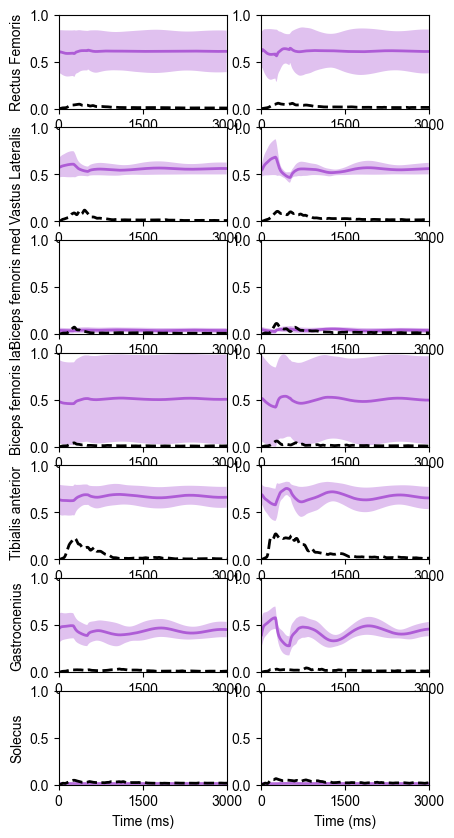

In [20]:
from matplotlib.ticker import MaxNLocator, MultipleLocator
muscle_name = ['Rectus Femoris', 'Vastus Lateralis', 'Biceps femoris med', 
               'Biceps femoris lat', 'Tibialis anterior', 'Gastrocnenius', 'Solecus']

muscle_r = ['recfem_r', 'vaslat_r', 'bflh_r', 'bfsh_r', 'tibant_r', 'gaslat_r', 'soleus_r'] 
muscle_l = ['recfem_l', 'vaslat_l', 'bflh_l', 'bfsh_l', 'tibant_l', 'gaslat_l', 'soleus_l'] 

plt.rcParams.update({
    "font.family": "Arial",  # specify font family here
    "font.size":10}) 

time_len = 300

x_time = np.arange(0, time_len*10, 10)


def aggregate_emg_activations(process_data):
    mus_data = {}
    for entry in process_data:
        data_dict = entry['data']
        for muscle, activations in data_dict.items():
            if muscle not in mus_data:
                mus_data[muscle] = []
            mus_data[muscle].append(activations)
    return mus_data

muscle_data = aggregate_emg_activations(processed_data)
muscle_data_high = aggregate_emg_activations(processed_data_high)
old_muscle_data = aggregate_emg_activations(processed_data_old)
old_muscle_data_high = aggregate_emg_activations(processed_data_old_high)

# Calculate the average for each muscle and plot
plt.figure(figsize=(10, 10))
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=3))  # Set 5 ticks on the x-axis

muscle_names = list(muscle_data.keys())  # Get all muscle names in order
num_muscles = len(muscle_names) // 2  # Assuming exactly half are left and half are right
color = ['dodgerblue', 'orangered', 'lime']

low_pearson = []

# Calculate and plot the average activations for corresponding muscle pairs
for i in range(num_muscles):
    left_muscle = muscle_names[i]
    right_muscle = muscle_names[i + num_muscles]
    
    left_avg = np.mean(muscle_data[left_muscle], axis=0)
    right_avg = np.mean(muscle_data[right_muscle], axis=0)
    combined_avg = (left_avg + right_avg) / 2
    
    l1 = []
    l = [l1]
    for k in pert_AP[0]:
        p_t = int(k['modelInfo']['perturbationTime']*100)
        #if fatigue:
            #p_t += 2200
        l[0].append(k['muscleInfo']['muscleActivation'][muscle_r[i]][p_t:p_t+time_len])
        l[0].append(k['muscleInfo']['muscleActivation'][muscle_l[i]][p_t:p_t+time_len])
    mean = np.mean(l[0], axis = 0)
    std = np.std(l[0], axis = 0)
    upper = mean + std
    lower = mean - std
    ax = plt.subplot(num_muscles, 4, 4*i + 1)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=2))  # Tick every 2 units
    ax.yaxis.set_major_locator(MaxNLocator(nbins=2))  # Max 5 ticks on y-axis
    
    ax.plot(x_time, np.mean(l[0], axis= 0), c = 'darkorchid', alpha = 0.7, linewidth = 2)
    ax.fill_between(x_time, lower.flatten(), upper.flatten(), facecolor = 'darkorchid', alpha = 0.3)
    
    ax.plot(combined_avg, c='black', linestyle = '--', linewidth=2)
    corr_matrix = np.corrcoef(np.mean(l[0], axis= 0), combined_avg[::10])
    pearson_corr = corr_matrix[0, 1]  # This extracts the correlation coefficient from the matrix
    low_pearson.append(pearson_corr)

    print("Low perturbation, Pearson Correlation Coefficient:", pearson_corr, 'for', muscle_name[i])
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 3000])
    ax.set_ylabel(muscle_name[i])
    if i == 6:
        ax.set_xlabel('Time (ms)')

high_pearson = []

for i in range(num_muscles):
    left_muscle = muscle_names[i]
    right_muscle = muscle_names[i + num_muscles]
    
    left_avg = np.mean(muscle_data_high[left_muscle], axis=0)
    right_avg = np.mean(muscle_data_high[right_muscle], axis=0)
    combined_avg = (left_avg + right_avg) / 2

    l1 = []
    l = [l1]
    for k in pert_AP_high[0]:
        p_t = int(k['modelInfo']['perturbationTime']*100)
        #if fatigue:
            #p_t += 2200
        l[0].append(k['muscleInfo']['muscleActivation'][muscle_r[i]][p_t:p_t+time_len])
        l[0].append(k['muscleInfo']['muscleActivation'][muscle_l[i]][p_t:p_t+time_len])
    mean = np.mean(l[0], axis = 0)
    std = np.std(l[0], axis = 0)
    upper = mean + std
    lower = mean - std
    
    ax = plt.subplot(num_muscles, 4, 4*i + 2)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=2))  # Tick every 2 units
    ax.yaxis.set_major_locator(MaxNLocator(nbins=2))  # Max 5 ticks on y-axis
    
    ax.plot(x_time, np.mean(l[0], axis= 0), c = 'darkorchid', alpha = 0.7, linewidth = 2)
    ax.fill_between(x_time, lower.flatten(), upper.flatten(), facecolor = 'darkorchid', alpha = 0.3)
    ax.plot(combined_avg, c='black', linestyle = '--', linewidth=2)
    corr_matrix = np.corrcoef(np.mean(l[0], axis= 0), combined_avg[::10])
    pearson_corr = corr_matrix[0, 1]  # This extracts the correlation coefficient from the matrix
    high_pearson.append(pearson_corr)

    print("High perturbation, Pearson Correlation Coefficient:", pearson_corr, 'for', muscle_name[i])
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 3000])
    #ax.set_ylabel(muscle_name[i])
    if i == 6:
        ax.set_xlabel('Time (ms)')

print(np.mean(low_pearson), np.mean(high_pearson))